In [2]:
%%bash
echo "🧹 Removing broken Triton & bitsandbytes folders..."

rm -rf /usr/local/lib/python3.*/dist-packages/triton*
rm -rf /usr/local/lib/python3.*/dist-packages/bitsandbytes*
rm -rf /usr/local/lib/python3.*/dist-packages/bnb*


🧹 Removing broken Triton & bitsandbytes folders...


In [3]:
%%bash
echo "⬇️ Installing PyTorch + bitsandbytes + triton combo known to work"

pip install -q --no-cache-dir torch==2.2.2+cu118 torchvision==0.17.2+cu118 torchaudio==2.2.2+cu118 \
  -f https://download.pytorch.org/whl/torch_stable.html

pip install -q --no-cache-dir triton==2.1.0.post1
pip install -q --no-cache-dir bitsandbytes==0.43.1

pip install -q --no-cache-dir \
  transformers==4.41.1 peft==0.11.1 accelerate==0.29.3 datasets einops requests


⬇️ Installing PyTorch + bitsandbytes + triton combo known to work
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.2/819.2 MB 261.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 240.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 161.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 190.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 166.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 180.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/2

ERROR: Could not find a version that satisfies the requirement triton==2.1.0.post1 (from versions: 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 3.0.0, 3.1.0, 3.2.0, 3.3.0, 3.3.1)
ERROR: No matching distribution found for triton==2.1.0.post1


In [1]:
from huggingface_hub import login
login(token="YOUR_HF_TOKEN")

In [2]:
import gc, torch, random
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from torch.utils.data import DataLoader, Dataset as TorchDataset

torch.cuda.empty_cache()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

In [4]:
MODEL_ID = "meta-llama/Llama-2-7b-hf"

bnb_cfg = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=True, token=True)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_cfg,
    device_map="auto",
    token=True
)

base_model = prepare_model_for_kbit_training(base_model)
base_model.train()

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [5]:
lora_cfg = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    use_rslora=True  # ← DRaFT-Q enables dynamic rank selection
)
model = get_peft_model(base_model, lora_cfg)
print(model.print_trainable_parameters())

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.0622
None


In [6]:
github_url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv"
df = pd.read_csv(github_url)

MAXLEN = 512

examples = []
for row in df.itertuples():
    prompt = f"summarize: {row.text}"
    enc = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=MAXLEN,
        return_tensors="pt",
    )
    enc["labels"] = enc["input_ids"].clone()
    examples.append({
        "input_ids": enc["input_ids"].squeeze(0),
        "attention_mask": enc["attention_mask"].squeeze(0),
        "labels": enc["labels"].squeeze(0),
    })

def collate(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch]),
    }

class MyDataset(TorchDataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

dloader = DataLoader(MyDataset(examples), batch_size=1, shuffle=True, collate_fn=collate)

In [7]:
optim = torch.optim.AdamW(model.parameters(), lr=2e-4)
losses = []

for step, batch in enumerate(dloader):
    if step >= 100:
        break

    batch = {k: v.to(DEVICE) for k, v in batch.items()}

    optim.zero_grad()
    loss = model(**batch).loss
    loss.backward()
    optim.step()

    losses.append(loss.item())
    if step % 10 == 0:
        print(f"Step {step:03d} | Loss {loss.item():.4f}")

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 000 | Loss 31.1358


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step 010 | Loss 0.7095
Step 020 | Loss 0.4987
Step 030 | Loss 0.3732
Step 040 | Loss 0.3422
Step 050 | Loss 0.3236
Step 060 | Loss 0.3851
Step 070 | Loss 0.4807
Step 080 | Loss 0.3318
Step 090 | Loss 0.4578


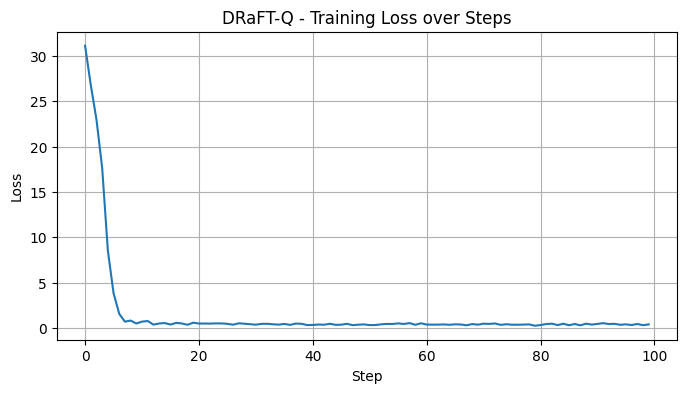

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(losses)
plt.title("DRaFT-Q - Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [12]:
model.eval()

prompt = "Summarize: The US stock market fell sharply today amid fears of a recession."
inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    gen = model.generate(**inputs, max_new_tokens=50)
    print(tokenizer.decode(gen[0], skip_special_tokens=True))

Summarize: The US stock market fell sharply today amid fears of a recession. everyone's worried about the US economy, which is in a downtrend.


In [11]:
# save_adapter.py
from peft import PeftModel
model.save_pretrained("draftq_adapter")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
